<a href="https://colab.research.google.com/github/sedaoturak/3D_Linear_Elasticity_FEniCS/blob/main/3D_Linear_Elasticity_Problem_FEniCS_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

**pymsh**: a Python interface for Gmsh, mesh generation tool

*Important note: after this installation code is executed, Colab kernel is restarted. It's okay to continue with the next line (dolfin installation)*

In [1]:
try:
  import pygmsh
except:
  !pip install --upgrade --user gmsh
  !pip install pygmsh
  exit()  # the kernel must be restarted again!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.3 MB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.2 MB/s 
     |████████████████████████████████| 167 kB 9.9 MB/s 
     |████████████████████████████████| 235 kB 39.6 MB/s 
     |████████████████████████████████| 51 kB 213 kB/s 


**dolfin**: the computational high-performance C++/Python backend of FEniCS

In [2]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2022-09-28 14:53:25--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2831 (2.8K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   2.76K  --.-KB/s    in 0s      

2022-09-28 14:53:25 (38.0 MB/s) - ‘/tmp/fenics-install.sh’ saved [2831/2831]

+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5710736/releases/pybind11-install.sh
+ [[ https://github.com/fem-on-colab/fem-on-colab.github.io/raw/5710736/releases/pybind11-install.sh == http* ]]
+ PYBIND11_

In [11]:
from fenics import *
import pygmsh
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Create Geometry

In [88]:
# Create a cylinder part with radius 20mm, height: 20mm
import pygmsh
height = 0.020 #dimensions in m
radius = 0.020 #dimensions in m
import pygmsh

with pygmsh.occ.Geometry() as geom:

  geom.characteristic_length_max=0.003  # smaller = more mesh elements
  cyl = geom.add_cylinder([0.0, 0.0, 0.0], [0.0, 0.0, height], radius, mesh_size=1)
  mesh = geom.generate_mesh()

# The geometry can be saved in .vtk format by this line
#mesh.write('sample.vtk')  # save to file

In [89]:
# Visualize the part
x, y, z = mesh.points.T
i, j, k = mesh.cells_dict['triangle'].T

fig = go.Figure(data=[
    go.Mesh3d(
        x=x, y=y, z=z,
        i=i, j=j, k=k,
        showscale=True,name='y', 
        opacity=0.5
    )
])

fig.show()

#Create Mesh

The geometry created by pygmsh needs to be converted to same mesh format of fenics (meshio). To do so, the tetrahedral cells of the geometry is found and save in .xdmf file. Mesh object is created by Mesh() function and .xdmf file is saved to this object.

In [91]:
import meshio
msh = mesh
# from the geometry, read and save the triangle and the tetrahedral cells
for cell in msh.cells:
    if cell.type == "triangle":
        triangle_cells = cell.data
    elif  cell.type == "tetra":
        tetra_cells = cell.data

# create the mesh from the points of the tetrahedral cells 
tetra_mesh = meshio.Mesh(points=msh.points, cells={"tetra": tetra_cells})

# save mesh to .xdmf file to call it as fenics mesh file in the simulation later on
meshio.write("mesh.xdmf", tetra_mesh)

# create a Mesh object
msh = Mesh()

# load mesh data by reading .xdmf file
filename = "mesh.xdmf"
f = XDMFFile(filename)
f.read(msh)

In [93]:
# --------- Visualize mesh --------- #
verts = msh.coordinates()
faces = msh.cells()
tri_vertices = verts[faces]

Xe = []
Ye = []
Ze = []
for T in tri_vertices:
    Xe += [T[k%3][0] for k in range(4)] + [ None]
    Ye += [T[k%3][1] for k in range(4)] + [ None]
    Ze += [T[k%3][2] for k in range(4)] + [ None]
       
plotly_wireframe = go.Scatter3d(x=Xe,
                     y=Ye,
                     z=Ze,
                     mode='lines',
                     name='',
                     line=dict(color= 'rgb(40,40,40)', width=0.5)
    )
fig = go.Figure(data=[plotly_wireframe])

fig.show()

#Define Materials Properties

The finite element problem below is adopted from https://fenics-solid-tutorial.readthedocs.io/en/latest/2DPlaneStrain/2D_Elasticity.html


In [94]:
# --------- Material Parameters --------- # 
# https://www.matweb.com/search/datasheet.aspx?bassnum=AMEAL00

# Density (kg/m3)
rho = Constant(2698.9)

# Young's modulus (Pa) and Poisson's ratio
E = 68e9 
nu = 0.30

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

#Define Problem

The part is simulated under compression loading by applying displacements. This can be changed to force application scenario. 

Before simulation, the displacement value ("delta_z") should be determined.

Friction is assumed to be present at the bottom surface of the part.

Body force is assumed as zero.

In [140]:
# --------- Force Definition --------- # 
mode = 'displacement'
delta_z = -0.005 # enter the displacement amount

# Body force = mass
grav = -9.8 # [N/kg] gravitational force
b = Constant((0.0, 0.0, -rho*grav))

if mode == 'displacement':
    f = Constant((0.0, 0.0, 0.0))
else:
    # E = stress / strain = (f/A) / strain -> f = E * strain * A
    f_mag = 33e6 * (np.abs(delta_z)/height) * (np.pi * 0.020**2)  # ???
    f = Constant((0.0, 0.0, -f_mag))

# --------- Vector Function Space Definition --------- #
# a function space is created from mesh for the displacements to be canculated
V = VectorFunctionSpace(msh, "CG", 1) # displacement function space
u_tr = TrialFunction(V)
u_test = TestFunction(V)

# --------- Boundary Conditions --------- #
def bot(x, on_boundary):
    return (on_boundary and near(x[2], 0.0)) # def of which points will be included in bc at bottom surface

def top(x, on_boundary):
    return (on_boundary and near(x[2], height)) # def of which points will be included in bc at top surface

bc_bot = DirichletBC(V, Constant((0.0, 0.0, 0.0)), bot)      # fixed bottom
bc_top = DirichletBC(V, Constant((0.0, 0.0, delta_z)), top)  # fixed top

bcs = [bc_bot, bc_top]

# Define surface for traction boundary condition
# Definition of Neumann boundary condition domain
boundaries = MeshFunction("size_t", msh, msh.topology().dim() - 1)
boundaries.set_all(0)
# define a subdomain for top boundary
top_b = AutoSubDomain(lambda x: near(x[2], height))
top_b.mark(boundaries, 1)

ds = Measure('ds', domain=msh, subdomain_data=boundaries)

# --------- Stress and Strain Equations --------- #
# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(3) + 2*mu*epsilon(u)

# --------- Weak Formulation of the Problem --------- #
a = inner(sigma(u_tr), epsilon(u_test))*dx
l = rho*dot(b, u_test)*dx + inner(f, u_test)*ds(1)

# --------- Solver --------- #
u = Function(V)
A, L = assemble_system(a, l, bcs)

solve(A, u.vector(), L)

1

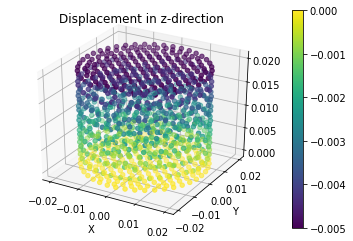

In [141]:
# --------- Plot of displacement in z dir. --------- #
plt.figure()

c = plot(u.sub(2))
plt.colorbar(c)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Displacement in z-direction')
plt.show()

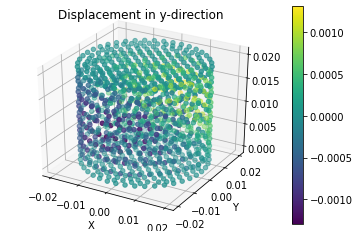

In [142]:
# --------- Plot of displacement in y dir. --------- #
plt.figure()

c = plot(u.sub(1))
plt.colorbar(c)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Displacement in y-direction')
plt.show()

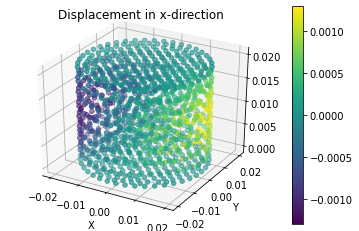

In [143]:
# --------- Plot of displacement in x dir. --------- #
plt.figure()

c = plot(u.sub(0))
plt.colorbar(c)
plt.xlabel('X')
plt.ylabel('Y')

plt.title('Displacement in x-direction')
plt.show()

#Post Processing

In [144]:
# --------- Stress Calculation from Displacement --------- #
stress = sigma(u)

# --------- Projection of Stress --------- #
def local_project(fce, space):
    lp_trial, lp_test = TrialFunction(space), TestFunction(space)
    lp_a = inner(lp_trial, lp_test)*dx
    lp_L = inner(fce, lp_test)*dx
    local_solver = LocalSolver(lp_a, lp_L)
    local_solver.factorize()
    lp_f = Function(space)
    local_solver.solve_local_rhs(lp_f)
    return lp_f

# create space from mesh
V0 = TensorFunctionSpace(msh, "DG", 0)
stress_2 = local_project(stress, V0) # stress values are projected onto this space

# find displacement components at each vertex
disp = u.compute_vertex_values()
n_verts = msh.coordinates().shape[0] # coordinates of vertices
# displacement components at each vertex are stored in order of vertices
disp = np.vstack([disp[(i*n_verts):((i+1)*n_verts)] for i in range(3)]).T

# stress components at each vertex are stored in order of vertices and displacements
stress_values = stress_2.compute_vertex_values()
stress_values = np.vstack([stress_values[(i*n_verts):((i+1)*n_verts)] for i in range(9)]).T

In [148]:
# --------------------
# Get triangles
# --------------------
from dolfin import vertices
import tqdm
from tqdm import notebook
mesh_triangles = []
for cell in tqdm.notebook.tqdm(cells(msh), total=msh.num_cells()):
    # print(cell.index())
    for facet in facets(cell):
        vertex_coords = []
        vertex_indices = []
        for vertex in vertices(facet):
            vertex_coords.append(list(vertex.point().array()))
            vertex_indices.append(vertex.index())
        mesh_triangles.append(vertex_indices)

  0%|          | 0/4622 [00:00<?, ?it/s]

In [163]:
scene_settings = dict(
        xaxis = dict(range=[-1.5*radius, 1.5*radius], showbackground=False, zerolinecolor="black"),
        yaxis = dict(range=[-1.5*radius, 1.5*radius], showbackground=False, zerolinecolor="black"),
        zaxis = dict(range=[0, height+0.005], showbackground=False, zerolinecolor="black"))


tris = np.array(mesh_triangles)
i, j, k = tris.T

x, y, z = (msh.coordinates() + disp).T

fig = go.Figure(data=[
    go.Mesh3d(
        x=x, y=y, z=z,
        # Intensity of each vertex, which will be interpolated and color-coded
        intensity=np.linalg.norm(disp, axis=1),         # total displacement
        # i, j and k give the vertices of triangles
        # here we represent the 4 triangles of the tetrahedron surface
        i=i, j=j, k=k,
        name='y',
        showscale=True, flatshading=True,
    ),
    # plotly_wireframe  # activate to include mesh
    ]) 
fig.update_layout(scene = scene_settings)
fig.update_layout(scene_aspectmode = 'manual',
                  scene_aspectratio=dict(x=1, y=1, z=0.8))

fig.show()